<a href="https://colab.research.google.com/github/lstarke/chatbots-watson-assistant/blob/main/watson_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install "watson-developer-cloud"
!pip install "ibm-watson"

import re
import matplotlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use('ggplot')
pd.options.display.max_colwidth = 150

###SETTING SKILL, API_KEY AND WATSON URL 

In [32]:
WAS_WORKSPACE = "ac7ad156-21e5-4fa8-950f-c7384c735337"
WAS_API_KEY = "N8sfqae0MvKX0NYU9L0hWYjbqYSOmKHHhsAE0Q5q-71U"
WAS_URL = "https://api.us-south.assistant.watson.cloud.ibm.com"

###TEST CONNECTION

In [33]:
from ibm_watson import AssistantV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

authenticator = IAMAuthenticator(WAS_API_KEY)
assistant = AssistantV1(
    version='2021-04-16',
    authenticator=authenticator
)

assistant.set_service_url(WAS_URL)
original_workspace_id = WAS_WORKSPACE

###TOTAL DE MENSAGENS

In [34]:
response = assistant.list_logs(workspace_id = original_workspace_id, page_limit = 100, include_count=True).get_result()
    
list_mount_examples = []

cursor_regex = r".*?cursor=(.*?)&"

logs = response['logs']
page = response['pagination']

while response:  
    for log in logs:
        if log["response"]:
            lresponse = log['response']            
            if 'input' in lresponse and 'text' in lresponse['input']:
              list_mount_examples.append(lresponse['input']['text'].strip())
            else:
              list_mount_examples.append(lresponse['input']['text'].strip())

    if not page:
        break

    cursor_res = re.search(cursor_regex, page['next_url'], re.IGNORECASE)
    cursor = None

    if cursor_res:
        cursor = cursor_res.group(1)
    if not cursor:
        break
  
    response = assistant.list_logs(workspace_id=wid, page_limit=100, cursor=cursor).get_result()
    
    logs = response['logs']
    page = response['pagination']

df_messages = pd.DataFrame({
    'Messages': list_mount_examples,        
}, columns=['Messages'])

print(f'Total de mensagens com o chatbot: {df_messages.shape[0]}')

Total de mensagens com o chatbot: 58


###TAXA DE TRANSBORDO

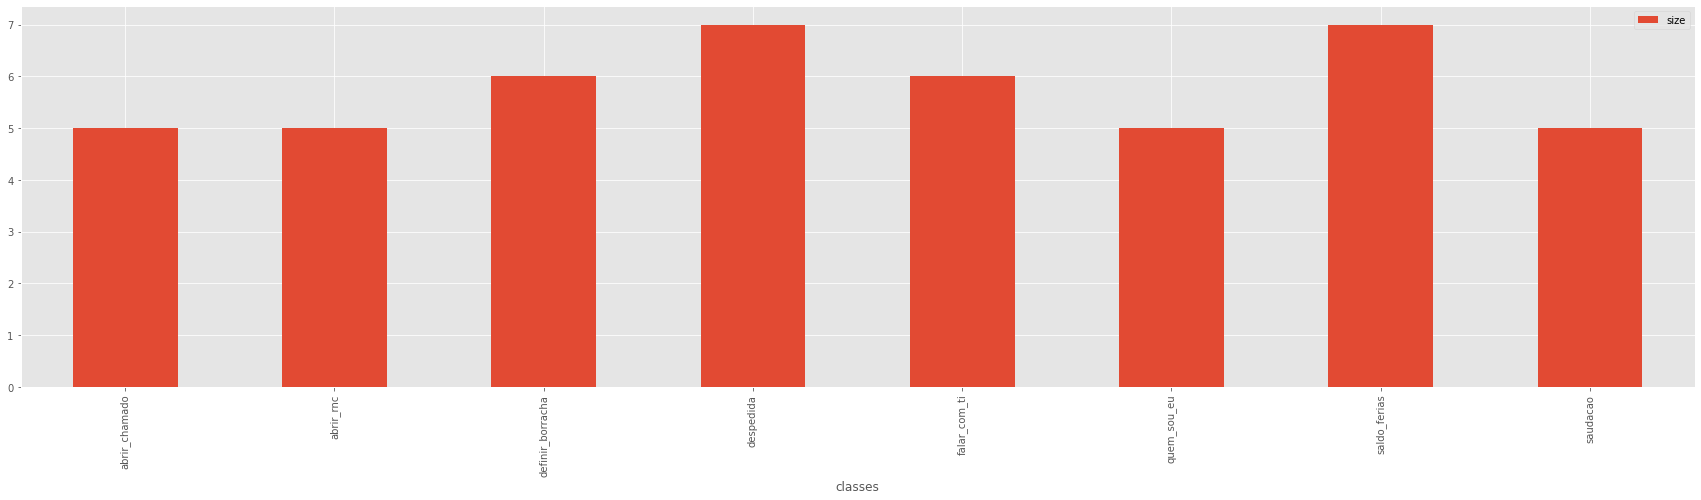

In [35]:
list_original_intents = assistant.list_intents(workspace_id = original_workspace_id).get_result()

list_original_examples = []
list_original_intent_names = []

intent_distribution = pd.DataFrame(columns=['classes', 'size'])
avg_size = 0;

for idx, intent in enumerate(list_original_intents['intents']):
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = list_original_intents['intents'][idx]['intent']
    ).get_result()
    avg_size = avg_size + len(examples['examples'])
    for example in examples['examples']:
        list_original_examples.append(example['text'])
        list_original_intent_names.append(list_original_intents['intents'][idx]['intent'])
        intent_distribution.loc[idx] = pd.Series({'classes':list_original_intents['intents'][idx]['intent'], 'size': len(examples['examples'])})

intent_distribution.plot(kind='bar',x='classes', y='size',figsize=(30,7))

intent_distribution = pd.DataFrame({
    'Example': list_original_examples,
    'Intent': list_original_intent_names
}, columns=['Example','Intent'])

In [36]:
intent_distribution.head()

,Example,Intent
0,estou com um problema,abrir_chamado
1,Gostaria de abrir um chamado,abrir_chamado
2,preciso de ajuda aqui,abrir_chamado
3,quero abrir um chamado,abrir_chamado
4,quero abrir um helpdesk,abrir_chamado


In [37]:
intent_distribution.Intent.value_counts()

saldo_ferias        7
despedida           7
definir_borracha    6
falar_com_ti        6
saudacao            5
abrir_chamado       5
abrir_rnc           5
quem_sou_eu         5
Name: Intent, dtype: int64

In [38]:
mask = (intent_distribution['Intent'] == 'falar_com_ti') | (intent_distribution['Intent'] == 'abrir_chamado')
print(f'Taxa de transbordo: {intent_distribution[mask].Intent.value_counts().sum()}')

Taxa de transbordo: 11


###MENSAGENS NÃO ENTENDIDAS

In [39]:
response = assistant.list_logs(workspace_id = original_workspace_id, page_limit = 100, include_count=True).get_result()
    
list_mount_examples = []

cursor_regex = r".*?cursor=(.*?)&"

logs = response['logs']
page = response['pagination']

while response:  
    for log in logs:
        if log["response"]:
            lresponse = log['response']            
            if 'output' in lresponse and 'text' in lresponse['output']:
              for text in lresponse['output']['text']:
                list_mount_examples.append(text.strip())
            else:
              for text in lresponse['output']['text']:
                list_mount_examples.append(text.strip())

    if not page:
        break

    cursor_res = re.search(cursor_regex, page['next_url'], re.IGNORECASE)
    cursor = None

    if cursor_res:
        cursor = cursor_res.group(1)
    if not cursor:
        break
  
    response = assistant.list_logs(workspace_id=wid, page_limit=100, cursor=cursor).get_result()
    
    logs = response['logs']
    page = response['pagination']

df_output_messages = pd.DataFrame({
    'Messages': list_mount_examples,        
}, columns=['Messages'])

misunderstood_messages = df_output_messages[df_output_messages['Messages'].str.contains('não entendi')].value_counts().sum()

print(f'Total de mensagens não entendidas: {misunderstood_messages}')

Total de mensagens não entendidas: 3


In [40]:
df_output_messages[df_output_messages['Messages'].str.contains('não entendi')].value_counts()

Messages                                            
Eu não entendi. Você pode tentar reformular a frase.    2
Eu não entendi o sentido.                               1
dtype: int64